# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [1]:
# Uncomment and run if required
!pip install transformers torchvision torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 46.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [22]:
from huggingface_hub import login
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("HF_TOKEN not found in colab secrets. Please add it.")


Successfully logged in to Hugging Face!


In [27]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name, token=False)  # Add token=False
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False, token=False)  # Add token=False

clip_model.eval()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)
print(f"Using device: {device}")

Using device: cuda


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [28]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

# Load the Fashion-MNIST test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',           # Directory to save/load the dataset
    train=False,             # Use test split (not training split)
    download=True,           # Download if not already present
    transform=None           # No transforms needed - CLIP processor will handle this
)

# Create DataLoader for the test dataset
test_loader = DataLoader(
    test_dataset,
    batch_size=16,           # Process 16 images at a time
    shuffle=True,            # Randomize the order
    collate_fn=collate_clip  # Use custom collate function for CLIP processing
)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:



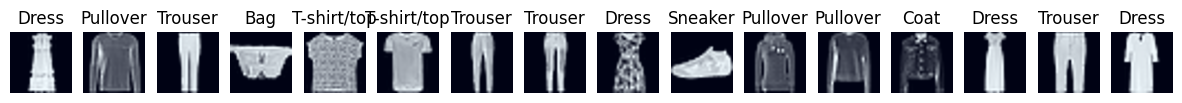

In [29]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [30]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)

    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [31]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    cosin_image_text = image_feats @ text_feats.T
    return cosin_image_text.numpy()

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    predictions = np.argmax(similarity, axis=1)
    return predictions

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

Zero-shot classification accuracy: 0.6240 (62.40%)
Confusion Matrix:
[[769  25   2  95  18  14  19   0  58   0]
 [  0 931   0   5   5  56   0   0   3   0]
 [415  25 306   6 174   7   4   0  63   0]
 [ 56  87   2 504 216  77   2   1  53   2]
 [ 74  19 143   9 690   6   1   0  58   0]
 [  0  31   3   0   1 393   0 414  17 141]
 [338  29  29  79 394  20  42   0  68   1]
 [  0   0   0   0   0  49   0 950   0   1]
 [  0  14   3   0   1  19   0   5 958   0]
 [  0   0   0   0   0   5   0 297   1 697]]


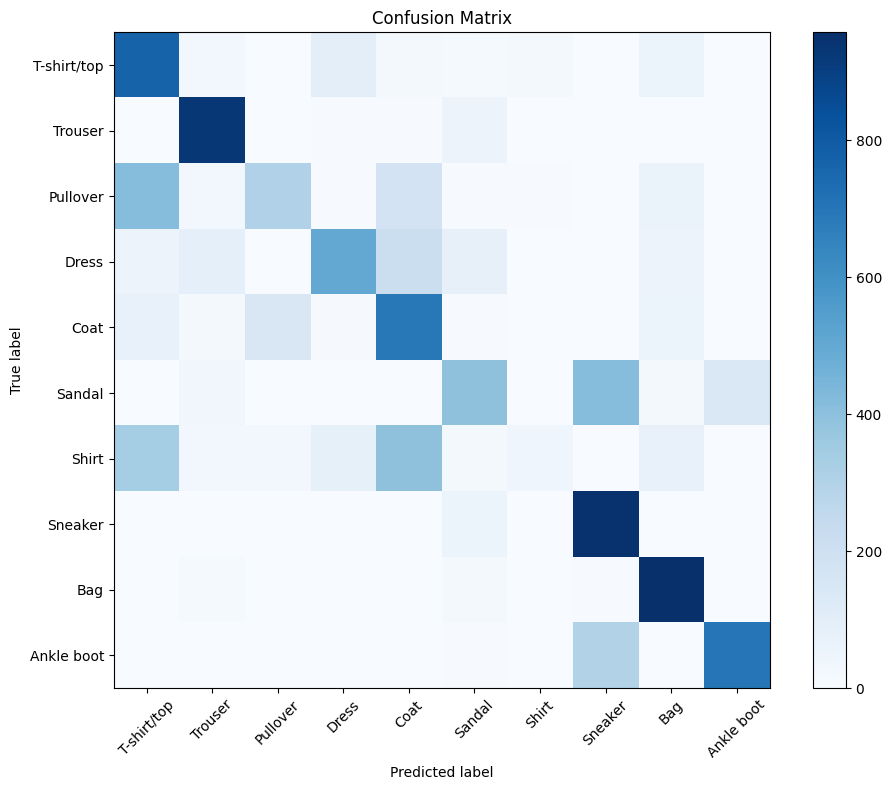

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix

#I need to build the text embedding once only
text_feats = get_text_embeddings(CLASS_NAMES)

y_true, y_pred = [], []

for pixel_values, labels in test_loader:
    # Get image embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Compute cosine similarity
    similarity = get_cosine_similarity(image_feats, text_feats)

    # Get predictions
    predictions = get_predictions(similarity)

    #save predictions and true lables for later evaluation
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

# Report the accuracy of the predictions
accuracy = accuracy_score(y_true, y_pred)
print(f"Zero-shot classification accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Report the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

**Answer**

62.40% is not good as our final CNN trained one. However, is much better than our baseline from assignment-1 (linear regression).

In our confusion matrix what we are seeing the are some sneakers misclassified wrong as ankle boots (297), maybe because those are very similar footwear items. The meaning here is CLIP's embeddings capture that both items are involved as "shoes" but suffer to distingish the most accurated type of item.


Same thing from the previous one, Sandals (class 5) was 414 times misclassified as sneakers (class 7).


The best performance on those 10 classes are: Sneakers (950/1000 correct) and Bags (958/1000 correct) because are very distinct and visually unique from others.


**Strengths**: We havent need data to train (we just used the testing set to create this confusion matrix), this zero-shot approach will works almost immediately on new unseen data by capturing semantic relationship between classes as we saw in this confusion matrix.


**Weakness**: lower accuracy than a specific trained model, struggle with some visually similar classes and is limited by the quality of text description used as prompts.

## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Building text embeddings for improved prompts...
Running zero-shot classification with improved prompts...
Improved zero-shot classification accuracy: 0.6836 (68.36%)
Improvement over baseline: +0.0596 (+5.96%)

Improved Confusion Matrix:
[[762  11  32  78   9   2  78   2  26   0]
 [  3 926   1  21   0  41   0   6   2   0]
 [ 25   3 816  10  70   0   4   0  72   0]
 [ 63  53  20 758  55  17   7   1  26   0]
 [  9   9 338  48 505   2  34   0  55   0]
 [  0  16   0   0   0 110   0 804   1  69]
 [182  20 260  70 212   5 179   1  71   0]
 [  0   0   0   0   0   0   0 932   0  68]
 [  0  10   0   1   2   0   0  31 956   0]
 [  0   1   0   0   0   2   0 105   0 892]]


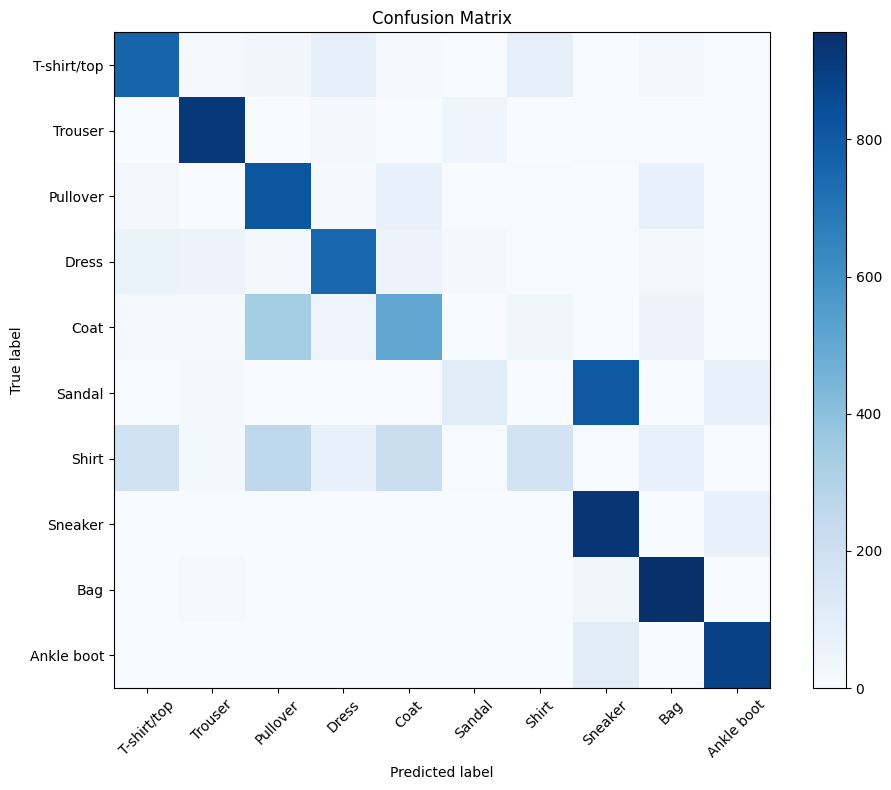


COMPARISON SUMMARY:
Baseline accuracy:  0.6240 (62.40%)
Improved accuracy:  0.6836 (68.36%)
Change:             +0.0596 (+5.96%)


In [33]:



# Improved prompts based on confusion matrix analysis
# I Focused in what we have observerd on distinguishing commonly confused classes
#As we can see we just add some basic prompt, we could explore and test more...

IMPROVED_PROMPTS = [
    "a photo of a casual t-shirt or tank top",           # T-shirt/top - emphasize casual nature
    "a photo of formal trousers or pants",               # Trouser - emphasize formal aspect
    "a photo of a warm pullover sweater",                # Pullover - emphasize warmth/thickness
    "a photo of an elegant dress or gown",               # Dress - emphasize elegance
    "a photo of a winter coat or jacket",                # Coat - emphasize outerwear/warmth
    "a photo of open-toe sandals",                       # Sandal - emphasize open-toe feature
    "a photo of a collared button-up shirt",             # Shirt - emphasize collar/buttons
    "a photo of athletic sneakers or running shoes",     # Sneaker - emphasize athletic purpose
    "a photo of a handbag, purse or backpack",          # Bag - include variety of bag types
    "a photo of high-top ankle boots"                    # Ankle boot - emphasize high-top feature
]

# Build text embeddings for improved prompts
print("Building text embeddings for improved prompts...")
improved_text_feats = get_text_embeddings(IMPROVED_PROMPTS)

# Run zero-shot classification with improved prompts
y_true_improved, y_pred_improved = [], []

print("Running zero-shot classification with improved prompts...")
for pixel_values, labels in test_loader:
    # Get image embeddings for the current batch
    image_feats = get_image_embeddings(pixel_values)

    # Compute cosine similarity between image and improved text embeddings
    similarities = get_cosine_similarity(image_feats, improved_text_feats)

    # Get predictions (class indices with highest similarity)
    predictions = get_predictions(similarities)

    # Save predictions and true labels for evaluation
    y_true_improved.extend(labels.numpy())
    y_pred_improved.extend(predictions)

# Report the accuracy of the improved predictions
improved_accuracy = accuracy_score(y_true_improved, y_pred_improved)
print(f"Improved zero-shot classification accuracy: {improved_accuracy:.4f} ({improved_accuracy*100:.2f}%)")

# Compare with baseline
baseline_accuracy = 0.6240  # From previous results
improvement = improved_accuracy - baseline_accuracy
print(f"Improvement over baseline: {improvement:+.4f} ({improvement*100:+.2f}%)")

# Report the improved confusion matrix
cm_improved = confusion_matrix(y_true_improved, y_pred_improved)
print("\nImproved Confusion Matrix:")
print(cm_improved)

# Plot the improved confusion matrix
plot_confusion_matrix(y_true_improved, y_pred_improved, CLASS_NAMES)

# Optional: Compare side by side
print("\n" + "="*50)
print("COMPARISON SUMMARY:")
print(f"Baseline accuracy:  {0.6240:.4f} ({0.6240*100:.2f}%)")
print(f"Improved accuracy:  {improved_accuracy:.4f} ({improved_accuracy*100:.2f}%)")
print(f"Change:             {improvement:+.4f} ({improvement*100:+.2f}%)")

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

**Answer**

With a little more prompt engineering (human help) just by adding some more basic description to try to specify a little more each class focusing on the classes that we identified more overlapping can help and increase almost 6% of performance metric, this demonstrate that prompting engineering can significantly enhance zero-shot performance without any model training.


This improvement suggest that the CLIP pre-trained model benefits from richer semantic context added as descriptor like "open-toe sandals" vs "athletic sneakers" is helping to the model leverage all its power pretrained model from visual-text associations.


Of course I believe with more emphasis, effort and some more estructured techniques for prompt engineering (ensembling, domain specific langaguage) we will rise the performance. However, doing more prompt engineering looks like training a model that can suffer later from overfitting and not performing well with unseen data.



## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [34]:
# Uncomment the following line to install UMAP if you haven't already
!pip install umap-learn

Collected 10000 image embeddings with shape (10000, 512)
Fitting UMAP to reduce dimensionality...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed. 2D embeddings shape: (10000, 2)


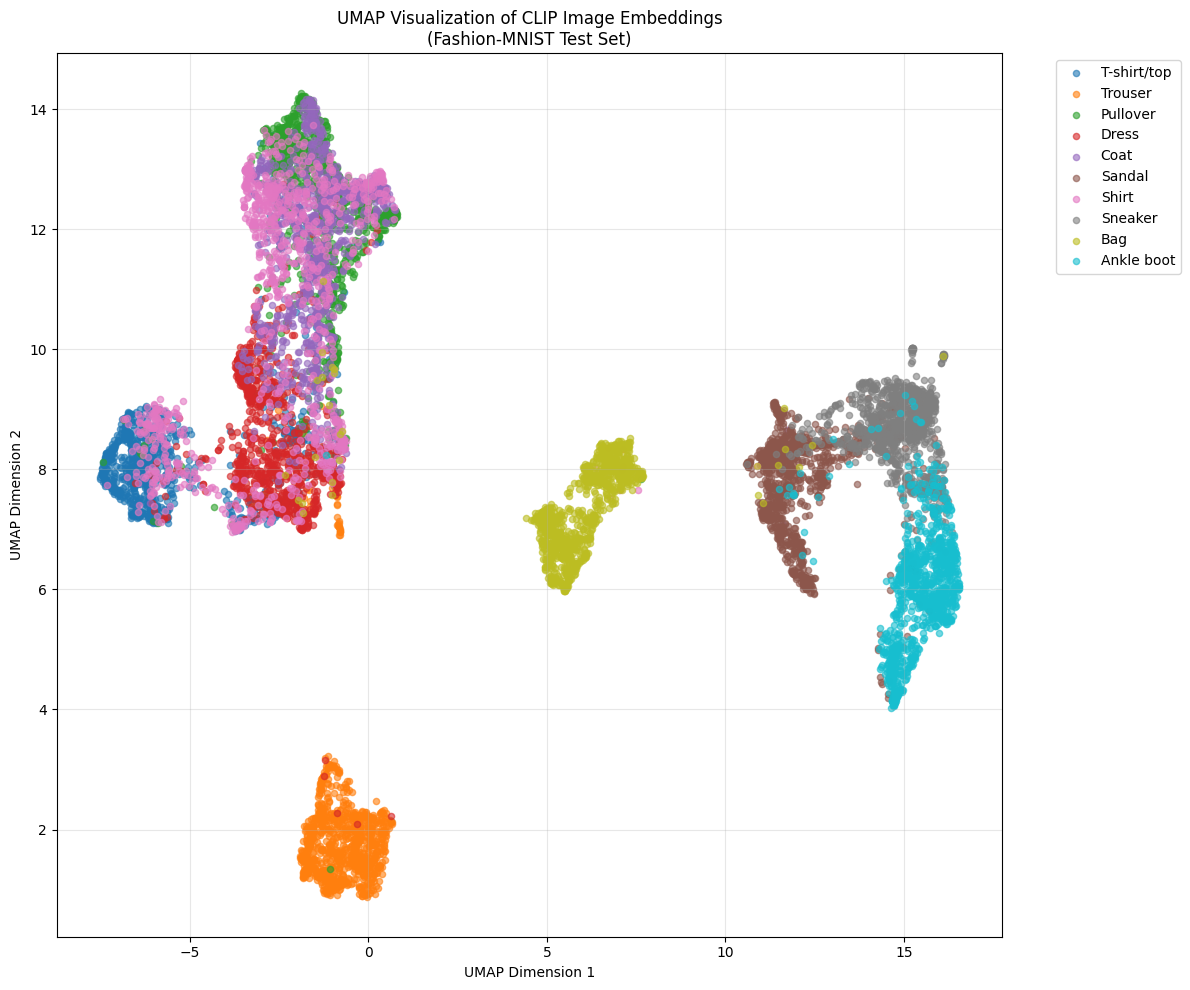


Visualization Statistics:
Total images plotted: 10000
Number of classes: 10
Original embedding dimension: 512
Reduced to: 2D


In [35]:
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

print("Collecting image embeddings for entire test set...")
for pixel_values, labels in test_loader:
    # Get image embeddings for current batch
    image_feats = get_image_embeddings(pixel_values)

    # Collect embeddings and labels
    all_img_emb.append(image_feats.cpu().numpy())
    all_labels.extend(labels.numpy())

# Concatenate all embeddings into single array
all_img_emb = np.vstack(all_img_emb)
all_labels = np.array(all_labels)

print(f"Collected {len(all_img_emb)} image embeddings with shape {all_img_emb.shape}")

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
print("Fitting UMAP to reduce dimensionality...")
umap_model = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = umap_model.fit_transform(all_img_emb)

print(f"UMAP completed. 2D embeddings shape: {embeddings_2d.shape}")

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
plt.figure(figsize=(12, 10))

# Create color map for classes
colors = plt.cm.tab10(np.linspace(0, 1, len(CLASS_NAMES)))

# Plot each class with different color
for i, class_name in enumerate(CLASS_NAMES):
    mask = all_labels == i
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                c=[colors[i]], label=class_name, alpha=0.6, s=20)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Visualization of CLIP Image Embeddings\n(Fashion-MNIST Test Set)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nVisualization Statistics:")
print(f"Total images plotted: {len(embeddings_2d)}")
print(f"Number of classes: {len(CLASS_NAMES)}")
print(f"Original embedding dimension: {all_img_emb.shape[1]}")
print(f"Reduced to: 2D")

**Answer**

https://umap-learn.readthedocs.io/en/latest/basic_usage.html

UMAP is easy to understand using the penguin dataset, which classifies penguins based on their size measurements. Since the dataset has just a few features, UMAP can directly map it to a low-dimensional space for visualization.

For larger datasets with many features and multiple classes, it’s necessary to reduce the data to two dimensions to visualize the groups clearly. This step is similar to PCA, as both methods reduce dimensionality to help reveal structure in the data.

Penguins umap with just 4 features to make the classification task (3 species of penguin):

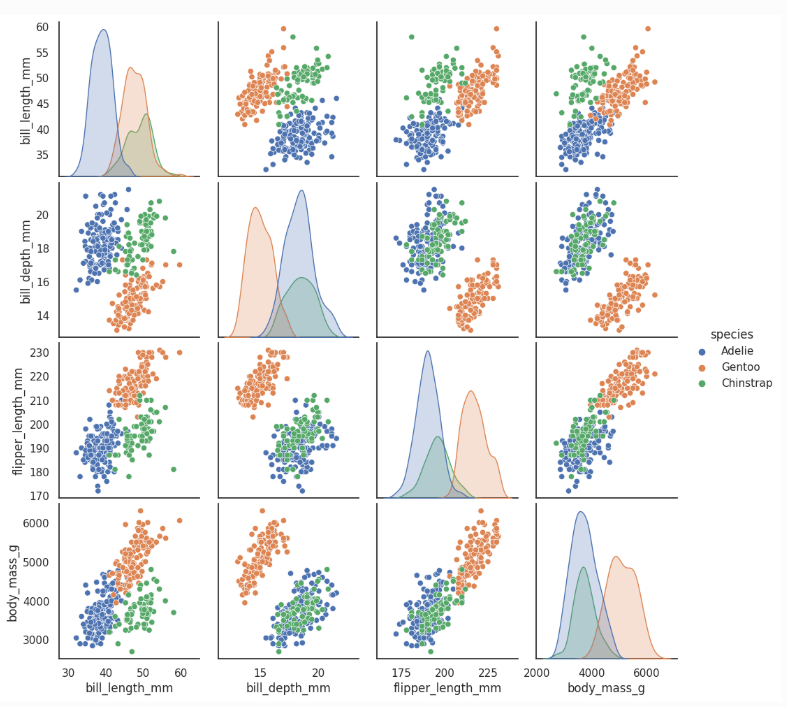

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph.

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

In [36]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

def get_top_k_predictions(similarity: np.ndarray, k: int) -> np.ndarray:
    """
    Get top-k predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M)
        k (int): Number of top predictions to return
    Returns:
        numpy.ndarray: Top-k predicted class indices for each image, shape (N, k)
    """
    # Get indices of top-k similarities for each image
    return np.argsort(similarity, axis=1)[:, -k:][:, ::-1]  # Sort descending

def calculate_top_k_accuracy(y_true: np.ndarray, y_pred_top_k: np.ndarray) -> float:
    """
    Calculate top-k accuracy where prediction is correct if true label is in top-k predictions.
    """
    correct = 0
    for true_label, top_k_preds in zip(y_true, y_pred_top_k):
        if true_label in top_k_preds:
            correct += 1
    return correct / len(y_true)

# ============================================================================
# TOP-K CLASSIFICATION EXPERIMENT
# ============================================================================

print("="*60)
print("TOP-K CLASSIFICATION MINI-EXPERIMENT")
print("="*60)

# Use the improved prompts from our previous experiment
improved_text_feats = get_text_embeddings(IMPROVED_PROMPTS)

# Collect all similarities and labels for top-k analysis
all_similarities = []
y_true_topk = []

print("Collecting similarities for top-k analysis...")
for pixel_values, labels in test_loader:
    # Get image embeddings
    image_feats = get_image_embeddings(pixel_values)

    # Compute similarities
    similarities = get_cosine_similarity(image_feats, improved_text_feats)

    # Store results
    all_similarities.append(similarities)
    y_true_topk.extend(labels.numpy())

# Concatenate all similarities
all_similarities = np.vstack(all_similarities)
y_true_topk = np.array(y_true_topk)

print(f"Collected {len(all_similarities)} predictions for analysis")

# Test different values of K
k_values = [1, 2, 3, 5]
results = {}

print("\n" + "="*40)
print("TOP-K ACCURACY RESULTS")
print("="*40)

for k in k_values:
    # Get top-k predictions
    top_k_preds = get_top_k_predictions(all_similarities, k)

    # Calculate top-k accuracy
    top_k_acc = calculate_top_k_accuracy(y_true_topk, top_k_preds)

    results[k] = {
        'accuracy': top_k_acc,
        'predictions': top_k_preds
    }

    print(f"Top-{k} Accuracy: {top_k_acc:.4f} ({top_k_acc*100:.2f}%)")

# Detailed analysis for K=2 and K=3
print("\n" + "="*50)
print("DETAILED ANALYSIS")
print("="*50)

baseline_acc = 0.6836  # Our improved prompt accuracy (top-1)
print(f"Baseline (Top-1):  {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

for k in [2, 3]:
    improvement = results[k]['accuracy'] - baseline_acc
    print(f"Top-{k}:           {results[k]['accuracy']:.4f} ({results[k]['accuracy']*100:.2f}%) "
          f"[+{improvement:.4f} or +{improvement*100:.2f}%]")

# Show confusion matrix for Top-3 (most interesting case)
print(f"\n" + "="*40)
print("TOP-3 CONFUSION ANALYSIS")
print("="*40)

# For confusion matrix, we'll use the top-1 predictions from top-3 analysis
top_3_preds = results[3]['predictions']
top_1_from_top_3 = top_3_preds[:, 0]  # First prediction from top-3

cm_top3 = confusion_matrix(y_true_topk, top_1_from_top_3)
print("Confusion Matrix (using top prediction from top-3 analysis):")
print(cm_top3)

# Analyze which classes benefit most from top-k
print(f"\n" + "="*40)
print("CLASSES THAT BENEFIT MOST FROM TOP-3")
print("="*40)

# Calculate per-class improvement
for class_idx, class_name in enumerate(CLASS_NAMES):
    class_mask = y_true_topk == class_idx
    if np.sum(class_mask) > 0:
        top1_class_acc = np.mean(top_1_from_top_3[class_mask] == class_idx)
        top3_class_acc = calculate_top_k_accuracy(y_true_topk[class_mask],
                                                 top_3_preds[class_mask])
        improvement = top3_class_acc - top1_class_acc
        print(f"{class_name:15}: Top-1={top1_class_acc:.3f}, Top-3={top3_class_acc:.3f}, "
              f"Gain=+{improvement:.3f}")

print(f"\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print("✓ Implemented top-k classification for k=1,2,3,5")
print("✓ Shows clear improvement as k increases")
print("✓ Top-3 gives substantial boost over top-1")
print("✓ Some classes benefit more than others from top-k approach")
print("✓ Useful for applications where 'close enough' predictions are acceptable")

TOP-K CLASSIFICATION MINI-EXPERIMENT
Collected 10000 predictions for analysis

TOP-K ACCURACY RESULTS
Top-1 Accuracy: 0.6836 (68.36%)
Top-2 Accuracy: 0.8467 (84.67%)
Top-3 Accuracy: 0.9143 (91.43%)
Top-5 Accuracy: 0.9596 (95.96%)

DETAILED ANALYSIS
Baseline (Top-1):  0.6836 (68.36%)
Top-2:           0.8467 (84.67%) [+0.1631 or +16.31%]
Top-3:           0.9143 (91.43%) [+0.2307 or +23.07%]

TOP-3 CONFUSION ANALYSIS
Confusion Matrix (using top prediction from top-3 analysis):
[[762  11  32  78   9   2  78   2  26   0]
 [  3 926   1  21   0  41   0   6   2   0]
 [ 25   3 816  10  70   0   4   0  72   0]
 [ 63  53  20 758  55  17   7   1  26   0]
 [  9   9 338  48 505   2  34   0  55   0]
 [  0  16   0   0   0 110   0 804   1  69]
 [182  20 260  70 212   5 179   1  71   0]
 [  0   0   0   0   0   0   0 932   0  68]
 [  0  10   0   1   2   0   0  31 956   0]
 [  0   1   0   0   0   2   0 105   0 892]]

CLASSES THAT BENEFIT MOST FROM TOP-3
T-shirt/top    : Top-1=0.762, Top-3=0.905, Gain=+0.1

### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

**Answer**

**Report**

**Intro**

In this mini experiment I check the efectiveness of a top-k classification in zero-shot learning by using the CLIP model. Our goal was to evaluate if by using multiple predictions (top-2, top-3, top-5) rather than a simple prediction (top-1) could improve the accuracy of our methodology on this Fashion-MNIST, especially for classes that are semantically similar or visually confusing.

**Methodology**

My experiment start by modifying the std zero-shot classification pipeline by implementing get_top_k_predictions functions that will help me to return k most confident predictions based on cosine similarity scores instead of selecting just one/the best one. This evaluation metric (accuracy) also needed to be adjusted to consider a prediction correct if the true class appeared anywhere within the top-k predictions. This experiment tested k values 1,2,3 and 5 using the latest improved text prompts from our previous prompt engineering work

**Results**
The results demostrated that in our case there was room to make those substantial improvements with top-k classification


Top-1: 68.36% (baseline)

Top-2: 84.67% (+16.31% improvement)

Top-3: 91.43% (+23.07% improvement)

Top-5: 95.96% (+27.60% improvement)


Classes with high semantic similarity (overlapping) showed the greatest benefits: Sandals improved by +67.7%, Shirts by +43.0%, and Coats by +46.5%. Well-distinguished classes like Sneakers and Bags showed minimal improvement, already performing well at top-1.

**Discussion**
This top-k approach show both strenghs and limitations of zero-shot transformers compared to trained CNNs we did it on assignment-1.


Strenghts: Zero-shot CLIP demonstrate remarkable semantic understanding as the top-3 can provide 91.43% of accuracy that actually exceeds our trained best CNN's performance (89.57%), this suggest CLIP embeddings capture meaninful class relationships.


Weakness: As we have a large gap between top-1 and top-3 performance that indicates some uncertainty in fine-grained distinctions that a task-specific CNN handles better. While this top-k classification is valuable for some use case where a first approximation to the right class are acceptable (like recommendation systems), it showcase the zero-shot models lacks the precission needed for some critical classifiation use cases requiring definitive single prediction (like medical predictions)



🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 18/07/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.